In [67]:
import pandas as  pd 
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd
 
def generate_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        morgan_gen = AllChem.GetMorganGenerator(radius=radius, fpSize=nBits)
        return list(morgan_gen.GetFingerprint(mol))
    return [0] * nBits
dataset = pd.read_csv("dataset/SMRT_dataset_with_dates.csv").sort_values(by='date').reset_index(drop=True)
dataset['fingerprint'] = dataset['SMILES'].apply(lambda x: generate_fingerprint(x)) 

In [68]:
import joblib

# load   model checkpoints
lgbm_model = joblib.load('checkpoints/lgbm_chronological_best_model.pkl')

# data splitting
dataset_clean = dataset.iloc[:int(0.85*dataset.shape[0]),:]
train_set = dataset_clean.iloc[:int(0.824*dataset_clean.shape[0]),:]
X_train = np.array(train_set['fingerprint'].tolist())
y_train = train_set['rt']

ftest_set = dataset.iloc[int(0.85*dataset.shape[0]):,]
X_ftest = np.array(ftest_set['fingerprint'].tolist())
y_ftest = ftest_set['rt']

# 1. SHAP

## SHAP summary results

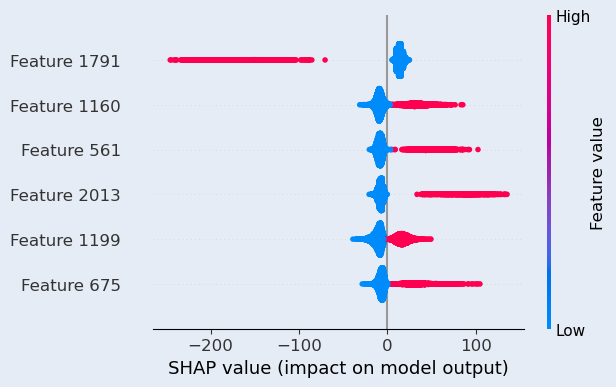

In [ ]:
import shap
import matplotlib.pyplot as plt

# Initialize JS visualization for the notebook
shap.initjs()

# Create the explainer
explainer = shap.TreeExplainer(lgbm_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_ftest)

# Create a summary plot
shap.summary_plot(shap_values, X_ftest, show=False,max_display=6)

# Customize background color
fig = plt.gcf()
fig.set_size_inches(6, 4)
fig.suptitle("")
ax = plt.gca()
bg_color = (229/255, 236/255, 246/255, 1)
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
ax.xaxis.label.set_color("black")
ax.yaxis.label.set_color("black")
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

plt.show()

## SHAP Mean Absolute Value

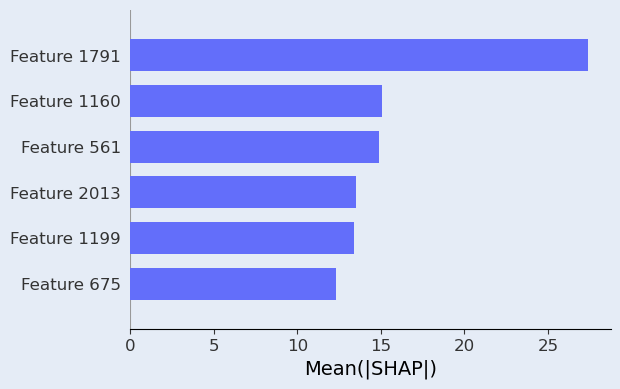

In [112]:
shap.summary_plot(shap_values, X_ftest, plot_type="bar", max_display=6, show=False)
fig = plt.gcf()
fig.set_size_inches(6, 4)
fig.suptitle("")
ax = plt.gca()
bg_color = (229/255, 236/255, 246/255, 1)
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
ax.xaxis.label.set_color("black")
ax.yaxis.label.set_color("black")
ax.set_xlabel("Mean(|SHAP|)", fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
for p in ax.patches:      # each bar is a patch
    p.set_facecolor('#636EFA')

plt.show()

In [105]:
for t in ax.texts:
    print(t)

## Permutation feature importance of LGBM

In [ ]:
from sklearn.inspection import permutation_importance
import warnings

# Suppress the specific UserWarning about feature names
warnings.filterwarnings('ignore', category=UserWarning, 
                        message='X does not have valid feature names')

# Calculate permutation importance on validation set
perm_importance = permutation_importance(
    lgbm_model, 
    X_ftest, 
    y_ftest,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Create importance dataframe
perm_importance_df = pd.DataFrame({
    'feature': range(X_ftest.shape[1]),
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nPermutation Importance (direct validation measurement):")
print(perm_importance_df.head(10))

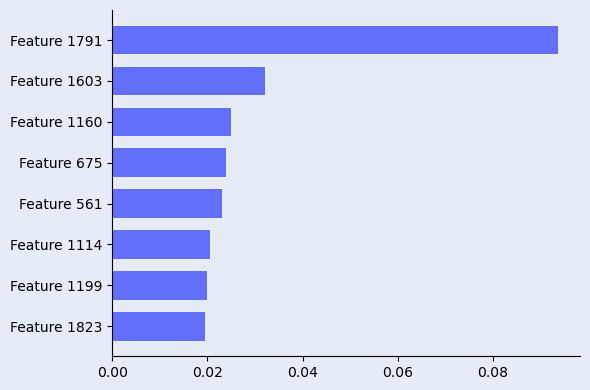

In [109]:
def plot_permutation_importance(features, importance_values, max_features=6):
    """Using features and importance values as the input"""
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Get top features
    n_show = min(max_features, len(features))
    top_features = features[:n_show]
    top_values = importance_values[:n_show]
    
    # Plot
    y_pos = np.arange(n_show)
    ax.barh(y_pos, top_values, height=0.7, color='#636EFA', align='center')
    
    # Set labels
    ax.set_yticks(y_pos)
    
    # Format as "Feature X"
    y_labels = []
    for i, feat in enumerate(top_features):
        digits = ''.join(filter(str.isdigit, str(feat)))
        y_labels.append(f"Feature {digits}" if digits else f"Feature {i+1}")
    
    # INVERT the y-axis to get highest at top
    ax.invert_yaxis()
    ax.set_yticklabels(y_labels)
    #ax.set_yticklabels(y_labels)
    
    # Style
    bg_color = (229/255, 236/255, 246/255, 1)
    fig.patch.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    return fig, ax

# Usage
fig, ax = plot_permutation_importance(
    features=perm_importance_df['feature'].tolist(),
    importance_values=perm_importance_df['importance_mean'].tolist(),
    max_features=8
)

## Default Feature importance of LGBM

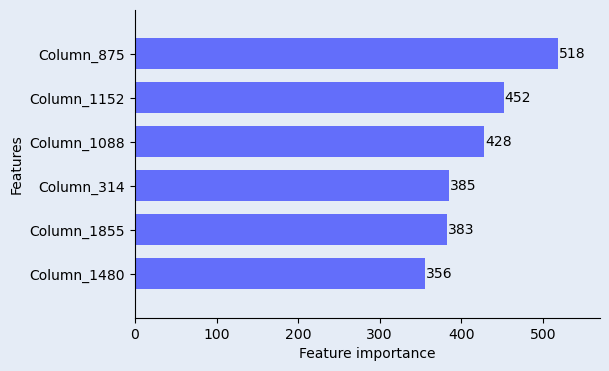

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Plot feature importance using LightGBM's built-in method
ax = lgb.plot_importance(lgbm_model, max_num_features=6, figsize=(6, 4), grid=False, color='#636EFA', height=0.7, title=None)

# Customize background color
bg_color = (229/255, 236/255, 246/255, 1)
fig = plt.gcf()
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

# Remove top and right spines to match SHAP style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize Y-axis labels to "Feature X"
# Get current labels and format them
current_labels = [item.get_text() for item in ax.get_yticklabels()]
new_labels = []
for label in current_labels:
    # Extract numbers from the label (e.g., "Column_875" -> "875")
    digits = ''.join(filter(str.isdigit, label))
    if digits:
        new_labels.append(f"Feature {digits}")
    else:
        new_labels.append(label)
ax.set_yticklabels(new_labels)

plt.show()

## SHAP for single molecule

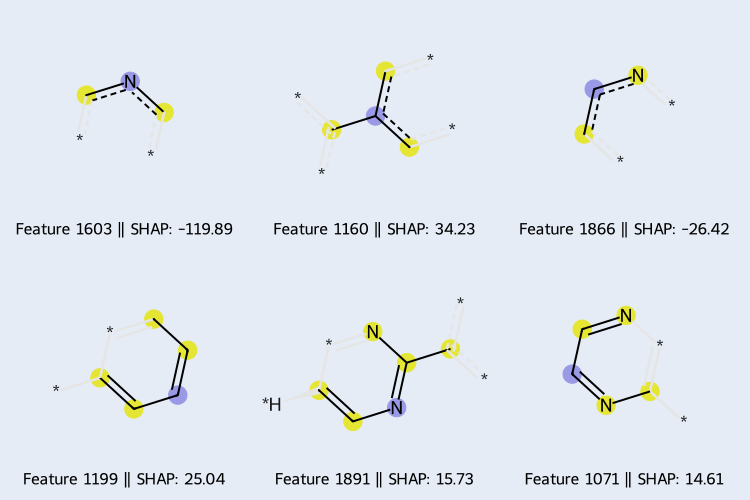

In [84]:
from rdkit.Chem import Draw
from IPython.display import display, SVG
import re

def visualize_top_bits(smiles, shap_values_row, num_bits=6, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if not mol: return
    morgan_gen = AllChem.GetMorganGenerator(radius=radius, fpSize=nBits)
    ao = AllChem.AdditionalOutput()
    ao.CollectBitInfoMap()
    fp = morgan_gen.GetFingerprint(mol, additionalOutput=ao)
    # Get indices of bits that are ON (1)
    on_bits = list(fp.GetOnBits())
    # Get bit info map
    bi = ao.GetBitInfoMap()
    
    # Filter SHAP values for these bits
    relevant_shap = {bit: shap_values_row[bit] for bit in on_bits}
    
    # Sort by absolute SHAP value
    top_bits = sorted(relevant_shap.keys(), key=lambda x: abs(relevant_shap[x]), reverse=True)[:num_bits]
    
    # Prepare data for drawing
    bits_to_draw = [(mol, bit, bi) for bit in top_bits]
    legends = [f"Feature {bit} || SHAP: {relevant_shap[bit]:.2f}" for bit in top_bits]
    
    if not bits_to_draw:
        print("No bits to visualize.")
        return

    # Draw grid
    # DrawMorganBits might return a string or an SVG object depending on RDKit version
    svg_output = Draw.DrawMorganBits(bits_to_draw, molsPerRow=min(len(bits_to_draw), 3), subImgSize=(250, 250), legends=legends, useSVG=True)
    
    # Extract string data if it's an SVG object
    if hasattr(svg_output, 'data'):
        svg_data = svg_output.data
    else:
        svg_data = svg_output

    # Change background color
    if isinstance(svg_data, str):
        svg_data = re.sub(r'fill:\s*#ffffff', 'fill:#E5ECF6', svg_data, flags=re.IGNORECASE)
        svg_data = re.sub(r'fill:\s*white', 'fill:#E5ECF6', svg_data, flags=re.IGNORECASE)
        svg_data = re.sub(r'rect style="opacity:1.0;fill:\s*#ffffff;stroke:none"', 'rect style="opacity:1.0;fill:#E5ECF6;stroke:none"', svg_data, flags=re.IGNORECASE)
        
        # 2. Inject a global background rect to cover the entire image
        bg_rect = '<rect width="100%" height="100%" fill="#E5ECF6"/>'
        
        if "<!-- END OF HEADER -->" in svg_data:
            svg_data = svg_data.replace("<!-- END OF HEADER -->", f"<!-- END OF HEADER -->\n{bg_rect}")
        else:
            # Fallback: insert after the opening svg tag
            svg_data = re.sub(r'(<svg[^>]*>)', lambda m: m.group(1) + f'\n{bg_rect}', svg_data, count=1)
    
    display(SVG(svg_data))

# Visualize for the first molecule in the test set
mol_id = 1
visualize_top_bits(ftest_set.iloc[mol_id]['SMILES'], shap_values[mol_id])

# blue: the central atom in the environment
# yellow: aromatic atoms
# gray: aliphatic ring atoms

## SHAP for individual features

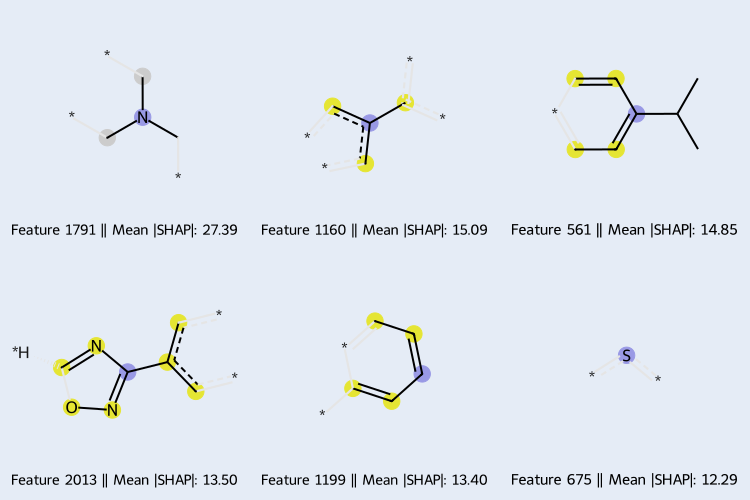

In [83]:
# Identify top features based on mean absolute SHAP value across the test set
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_features = np.argsort(mean_abs_shap)[::-1][:6]  # Top 6 features

bits_to_draw = []
legends = []

for bit_idx in top_features:
    # Find samples in the test set where this bit is present (value == 1)
    sample_indices = np.where(X_ftest[:, bit_idx] == 1)[0]
    
    if len(sample_indices) > 0:
        # Pick the molecule where this feature has the highest impact (highest absolute SHAP value)
        # This ensures we visualize the feature in a relevant context
        best_sample_idx = sample_indices[np.argmax(np.abs(shap_values[sample_indices, bit_idx]))]
        
        smiles = ftest_set.iloc[best_sample_idx]['SMILES']
        mol = Chem.MolFromSmiles(smiles)
        
        # Regenerate bit info for this specific molecule to draw the bit
        morgan_gen = AllChem.GetMorganGenerator(radius=2, fpSize=2048)
        ao = AllChem.AdditionalOutput()
        ao.CollectBitInfoMap()
        _ = morgan_gen.GetFingerprint(mol, additionalOutput=ao)
        bi = ao.GetBitInfoMap()
        
        bits_to_draw.append((mol, int(bit_idx), bi))
        legends.append(f"Feature {bit_idx} || Mean |SHAP|: {mean_abs_shap[bit_idx]:.2f}")

if bits_to_draw:
    # Draw grid
    svg_output = Draw.DrawMorganBits(bits_to_draw, molsPerRow=3, subImgSize=(250, 250), legends=legends, useSVG=True)

    # Extract string data
    if hasattr(svg_output, 'data'):
        svg_data = svg_output.data
    else:
        svg_data = svg_output

    # Apply background color style (consistent with previous plots)
    if isinstance(svg_data, str):
        svg_data = re.sub(r'fill:\s*#ffffff', 'fill:#E5ECF6', svg_data, flags=re.IGNORECASE)
        svg_data = re.sub(r'fill:\s*white', 'fill:#E5ECF6', svg_data, flags=re.IGNORECASE)
        svg_data = re.sub(r'rect style="opacity:1.0;fill:\s*#ffffff;stroke:none"', 'rect style="opacity:1.0;fill:#E5ECF6;stroke:none"', svg_data, flags=re.IGNORECASE)
        
        # Inject global background rect
        bg_rect = '<rect width="100%" height="100%" fill="#E5ECF6"/>'
        if "<!-- END OF HEADER -->" in svg_data:
            svg_data = svg_data.replace("<!-- END OF HEADER -->", f"<!-- END OF HEADER -->\n{bg_rect}")
        else:
            svg_data = re.sub(r'(<svg[^>]*>)', lambda m: m.group(1) + f'\n{bg_rect}', svg_data, count=1)

    display(SVG(svg_data))
else:
    print("No features found to visualize.")

# 2. Captum with GCN for interpretation

## Loading all data and models

In [1]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from pyg_chemprop_utils import smiles2data
from pyg_chemprop import make_prediction
from torch_geometric.loader import DataLoader
import torch

import pandas as pd 

dataset = pd.read_csv("dataset/SMRT_dataset_with_dates.csv").sort_values(by='date').reset_index(drop=True)
dataset_clean = dataset.iloc[:int(0.85*dataset.shape[0]),:]
ftest_set = dataset.iloc[int(0.85*dataset.shape[0]):,]
train_set,valid_set = dataset_clean.iloc[:int(0.824*dataset_clean.shape[0]),:], dataset_clean.iloc[int(0.824*dataset_clean.shape[0]):,:]

smiles_col = "SMILES"  
rt_col = "rt"          

train_graphs = []
for _, row in train_set.iterrows():
    data = smiles2data(row[smiles_col])
    data['y'] = row[rt_col]
    if data is not None:
        train_graphs.append(data)

valid_graphs = []
for _, row in valid_set.iterrows():
    data = smiles2data(row[smiles_col])
    data['y'] = row[rt_col]
    if data is not None:
        valid_graphs.append(data)

ftest_graphs = []
for _, row in ftest_set.iterrows():
    data = smiles2data(row[smiles_col])
    data['y'] = row[rt_col]
    if data is not None:
        ftest_graphs.append(data)
len(train_graphs), len(valid_graphs), len(ftest_graphs)

(56058, 11974, 12006)

In [2]:
batch_size=128
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_graphs, batch_size=batch_size, shuffle=False)
ftest_loader = DataLoader(ftest_graphs, batch_size=batch_size, shuffle=False)

In [5]:
# Create config dictionary as expected by make_prediction
gcn_model = torch.load('checkpoints/GCN_chronological_best_model.pt', weights_only=False,map_location=torch.device('cpu'))
config = {"model": gcn_model}

# Make predictions
y_pred_tensor, y_true_tensor = make_prediction(config, ftest_loader, device=torch.device('cpu'))

# Convert to numpy
y_pred = y_pred_tensor.numpy()
y_true = y_true_tensor.numpy()

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")

100%|██████████| 94/94 [00:03<00:00, 27.87it/s]

MSE: 7866.24
R2 Score: 0.82


## Captum explanation

In [6]:
import networkx as nx
import numpy as np
from rdkit import Chem
from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def get_atomic_symbol(atomic_number):
    # Get the periodic table
    pt = Chem.GetPeriodicTable()
    symbol = pt.GetElementSymbol(atomic_number)
    return symbol

def to_molecule(data):
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = get_atomic_symbol(data['x'][:100].index(1.0)+1)
        del data['x']
    return g


In [ ]:
from captum.attr import Saliency, IntegratedGradients
device  = torch.device('cpu')
def model_forward(edge_mask, data):
    
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    #out = gcn_model(data.x, data.edge_index, batch, edge_mask)
    out = gcn_model(data)

    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

In [ ]:
to_molecule(data)

In [ ]:
import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict


data = random.choice(ftest_graphs)
mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

In [ ]:
## Gemini captum

# 3. Why model succeed or fail on molecules

## Vsualize feature shap value for a good and a bad prediction

--- Best Prediction (Index: 11968) ---
SMILES: O=C(CC1CC1)N1CC(F)(F)C[C@H]1c1nnc(-c2ccccc2)o1
Actual RT: 803.70, Predicted RT: 803.70, Error: 0.0002


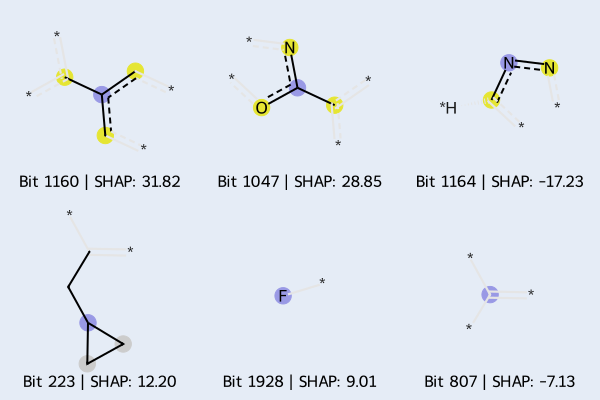



--- Worst Prediction (Index: 9251) ---
SMILES: CCOc1ccc(CNc2nc3ccccc3n2CCN(CC)CC)cc1
Actual RT: 1303.10, Predicted RT: 355.05, Error: 948.0533


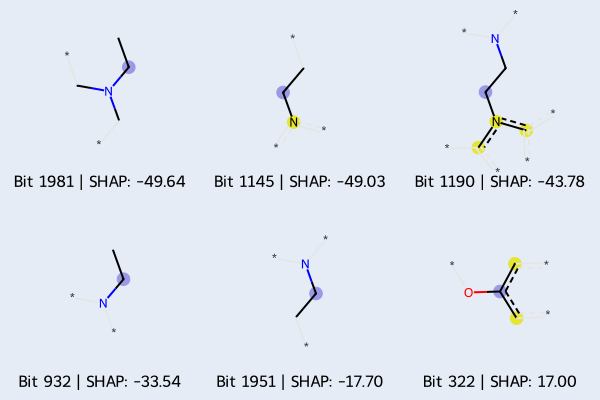

In [40]:
import warnings

# Suppress the specific UserWarning about feature names
warnings.filterwarnings('ignore', category=UserWarning, 
                        message='X does not have valid feature names')

# Calculate predictions
y_pred = lgbm_model.predict(X_ftest)
errors = np.abs(y_ftest.values - y_pred)

# Find index of best (min error) and worst (max error) predictions
best_idx = np.argmin(errors)
worst_idx = np.argmax(errors)

# Visualize Best Prediction
print(f"--- Best Prediction (Index: {best_idx}) ---")
print(f"SMILES: {ftest_set.iloc[best_idx]['SMILES']}")
print(f"Actual RT: {y_ftest.iloc[best_idx]:.2f}, Predicted RT: {y_pred[best_idx]:.2f}, Error: {errors[best_idx]:.4f}")
visualize_top_bits(ftest_set.iloc[best_idx]['SMILES'], shap_values[best_idx])

print("\n" + "="*80 + "\n")

# Visualize Worst Prediction
print(f"--- Worst Prediction (Index: {worst_idx}) ---")
print(f"SMILES: {ftest_set.iloc[worst_idx]['SMILES']}")
print(f"Actual RT: {y_ftest.iloc[worst_idx]:.2f}, Predicted RT: {y_pred[worst_idx]:.2f}, Error: {errors[worst_idx]:.4f}")
visualize_top_bits(ftest_set.iloc[worst_idx]['SMILES'], shap_values[worst_idx])

## Frequency of top feautures in training dataset

In [41]:
# counting the frequency of the bits in training datasets
import plotly.express as px

dataset_clean = dataset.iloc[:int(0.85*dataset.shape[0]),:]
train_set = dataset_clean.iloc[:int(0.824*dataset_clean.shape[0]),:]
X_train = np.array(train_set['fingerprint'].tolist())
y_train = train_set['rt']

def get_top_bits_indices(shap_values_row, fingerprint_row, num_bits=6):
    # Get indices of bits that are ON (1)
    on_bits = np.where(fingerprint_row == 1)[0]
    # Filter SHAP values for these bits
    relevant_shap = {bit: shap_values_row[bit] for bit in on_bits}
    # Sort by absolute SHAP value
    top_bits = sorted(relevant_shap.keys(), key=lambda x: abs(relevant_shap[x]), reverse=True)[:num_bits]
    return top_bits

# Get top bits
top_bits_best = get_top_bits_indices(shap_values[best_idx], X_ftest[best_idx])
top_bits_worst = get_top_bits_indices(shap_values[worst_idx], X_ftest[worst_idx])

# Prepare data for Plotly
data = []
for bit in top_bits_best:
    ratio = X_train[:, bit].mean()
    data.append({'Bit': f'Bit {bit}', 'Frequency': ratio, 'Prediction': 'Best Prediction'})

for bit in top_bits_worst:
    ratio = X_train[:, bit].mean()
    data.append({'Bit': f'Bit {bit}', 'Frequency': ratio, 'Prediction': 'Worst Prediction'})

df_counts = pd.DataFrame(data)

# Create grouped bar plot
fig = px.bar(df_counts, x='Bit', y='Frequency', color='Prediction', barmode='group',
             color_discrete_map={'Best Prediction': '#636EFA', 'Worst Prediction': '#EF553B'})

# Apply consistent styling
fig.update_layout(
    plot_bgcolor='rgba(229, 236, 246, 1)',
    paper_bgcolor='rgba(229, 236, 246, 1)',
    margin=dict(l=20, r=20, t=40, b=20),
    yaxis_tickformat='.1%',
    xaxis_title="Top SHAP Bits",
    yaxis_title="Frequency in Training Set",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
)

fig.show()

In [16]:
X_train

array(['<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x17d407610>',
       '<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x17ce1aab0>',
       '<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x17b18a880>',
       ...,
       '<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x17d413df0>',
       '<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x17d430040>',
       '<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x17c78cf20>'],
      dtype='<U70')

## Similarity and MCS visualization between best and worst predicted molecules

--- Most Similar to Best Prediction ---
Query SMILES: O=C(CC1CC1)N1CC(F)(F)C[C@H]1c1nnc(-c2ccccc2)o1


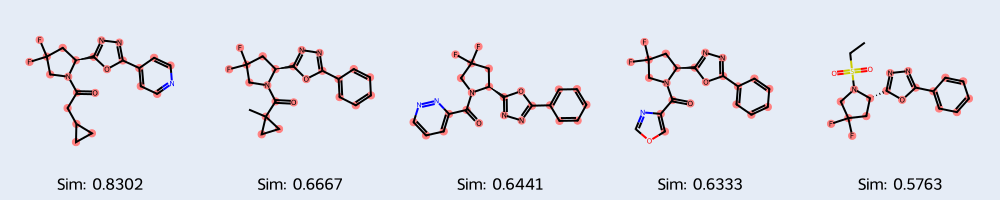



--- Most Similar to Worst Prediction ---
Query SMILES: CCOc1ccc(CNc2nc3ccccc3n2CCN(CC)CC)cc1


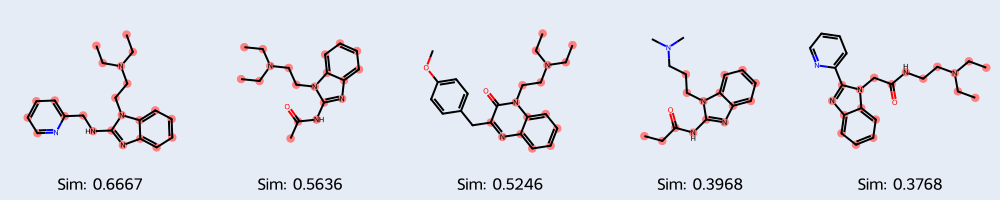

In [42]:
from rdkit.Chem import rdFMCS

def find_and_visualize_similar_mols(query_smiles, train_df, X_train_fp, n_similar=5, title_prefix=""):
    query_mol = Chem.MolFromSmiles(query_smiles)
    if not query_mol: return
    
    # Generate query fingerprint vector
    query_fp_list = generate_fingerprint(query_smiles)
    query_fp_arr = np.array(query_fp_list)
    
    # Calculate Tanimoto similarity using numpy for speed
    # T(A, B) = (A . B) / (sum(A) + sum(B) - A . B)
    intersection = np.dot(X_train_fp, query_fp_arr)
    sum_train = np.sum(X_train_fp, axis=1)
    sum_query = np.sum(query_fp_arr)
    union = sum_train + sum_query - intersection
    
    # Avoid division by zero
    tanimoto_scores = np.divide(intersection, union, out=np.zeros_like(intersection, dtype=float), where=union!=0)
    
    # Get top N indices
    top_indices = np.argsort(tanimoto_scores)[::-1][:n_similar]
    
    mols_to_draw = []
    legends = []
    highlight_lists = []
    
    for idx in top_indices:
        score = tanimoto_scores[idx]
        target_smiles = train_df.iloc[idx]['SMILES']
        target_mol = Chem.MolFromSmiles(target_smiles)
        
        if target_mol:
            # Find Maximum Common Substructure (MCS)
            res = rdFMCS.FindMCS([query_mol, target_mol])
            if res.numAtoms > 0:
                mcs_mol = Chem.MolFromSmarts(res.smartsString)
                match = target_mol.GetSubstructMatch(mcs_mol)
                highlight_lists.append(list(match))
            else:
                highlight_lists.append([])
            
            mols_to_draw.append(target_mol)
            legends.append(f"Sim: {score:.4f}")
        
    if mols_to_draw:
        # Draw grid
        svg_output = Draw.MolsToGridImage(mols_to_draw, molsPerRow=n_similar, subImgSize=(200, 200), 
                                          legends=legends, highlightAtomLists=highlight_lists, useSVG=True)
        
        # Apply background color style
        if hasattr(svg_output, 'data'):
            svg_data = svg_output.data
        else:
            svg_data = svg_output
        if isinstance(svg_data, str):
            # Replace existing white fills
            svg_data = re.sub(r'fill:\s*#ffffff', 'fill:#E5ECF6', svg_data, flags=re.IGNORECASE)
            svg_data = re.sub(r'fill:\s*white', 'fill:#E5ECF6', svg_data, flags=re.IGNORECASE)
            svg_data = re.sub(r'rect style="opacity:1.0;fill:\s*#ffffff;stroke:none"', 'rect style="opacity:1.0;fill:#E5ECF6;stroke:none"', svg_data, flags=re.IGNORECASE)
            
            # Inject global background rect
            bg_rect = '<rect width="100%" height="100%" fill="#E5ECF6"/>'
            if "<!-- END OF HEADER -->" in svg_data:
                svg_data = svg_data.replace("<!-- END OF HEADER -->", f"<!-- END OF HEADER -->\n{bg_rect}")
            else:
                svg_data = re.sub(r'(<svg[^>]*>)', lambda m: m.group(1) + f'\n{bg_rect}', svg_data, count=1)
                
        print(f"--- {title_prefix} ---")
        print(f"Query SMILES: {query_smiles}")
        display(SVG(svg_data))

# Visualize for Best Prediction
find_and_visualize_similar_mols(ftest_set.iloc[best_idx]['SMILES'], train_set, X_train, title_prefix="Most Similar to Best Prediction")

print("\n" + "="*80 + "\n")

# Visualize for Worst Prediction
find_and_visualize_similar_mols(ftest_set.iloc[worst_idx]['SMILES'], train_set, X_train, title_prefix="Most Similar to Worst Prediction")

# 4. Captum for node and edge explanations

## PYG built-in explainer for edges

In [57]:
errors.max()

967.7685

In [50]:
gcn_model = torch.load('checkpoints/GCN_chronological_best_model.pt', weights_only=False,map_location=torch.device('cpu'))
config = {"model": gcn_model}

# Make predictions
#y_pred_tensor, y_true_tensor = make_prediction(config, ftest_loader, device=torch.device('cpu'))
y_pred = y_pred_tensor.numpy().squeeze()
y_ftest = y_true_tensor.numpy()
errors = np.abs(y_ftest - y_pred)

# Find index of best (min error) and worst (max error) predictions
best_idx = np.argmin(errors)
worst_idx = np.argmax(errors)

# Visualize Best Prediction
print(f"--- Best Prediction (Index: {best_idx}) ---")
print(f"SMILES: {ftest_set.iloc[best_idx]['SMILES']}")
print(f"Actual RT: {y_ftest[best_idx]:.2f}, Predicted RT: {y_pred[best_idx]:.2f}, Error: {errors[best_idx]:.4f}")


print("\n" + "="*80 + "\n")

# Visualize Worst Prediction
print(f"--- Worst Prediction (Index: {worst_idx}) ---")
print(f"SMILES: {ftest_set.iloc[worst_idx]['SMILES']}")
print(f"Actual RT: {y_ftest[worst_idx]:.2f}, Predicted RT: {y_pred[worst_idx]:.2f}, Error: {errors[worst_idx]:.4f}")


--- Best Prediction (Index: 4392) ---
SMILES: O=C(NCc1ccccc1Cl)C1CCN(S(=O)(=O)c2cc(C(=O)N3CCCC3)cs2)CC1
Actual RT: 815.00, Predicted RT: 815.00, Error: 0.0031


--- Worst Prediction (Index: 1142) ---
SMILES: O=C([O-])[C@H](CC(=O)N1C[C@H]2CCCC[C@H]2C1)Cc1ccccc1
Actual RT: 0.30, Predicted RT: 968.07, Error: 967.7685


--- GNNExplainer Analysis (Best Prediction) ---

GNNExplainer  (Edges): Best Prediction | Prediction: 1487.15
------------------------------------------------------------


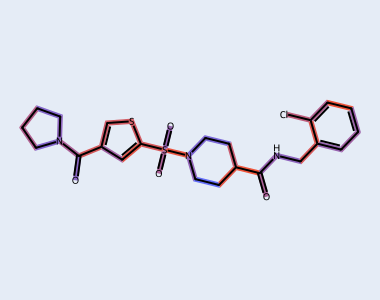

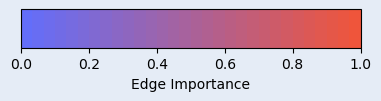



--- GNNExplainer Analysis (Worst Prediction) ---

GNNExplainer (Edges): Worst Prediction | Prediction: 987.05
-----------------------------------------------------------


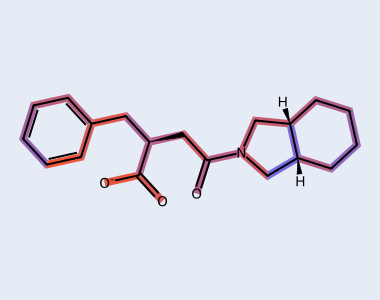

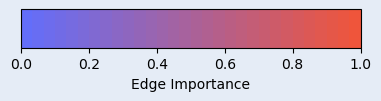

In [ ]:
import torch
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw

from IPython.display import SVG, display

import matplotlib.pyplot as plt
from matplotlib import colors,colorbar
from matplotlib.colors import LinearSegmentedColormap

from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer



BG_RGBA = (229 / 255, 236 / 255, 246 / 255, 1) 
BG_HEX = "#E5ECF6"

_COLOR_CMAP = LinearSegmentedColormap.from_list(
    "blue_to_red",
    ["#636EFA", "#EF553B"],
    N=30,
)

def _smiles_to_data_best_effort(smiles: str, device: torch.device):
    """Try to build a PyG Data that matches the trained model's featurization."""
    from pyg_chemprop_utils import smiles2data
    last_err = None
    for explicit_h in (False, True):
        try:
            data = smiles2data(smiles, explicit_h=explicit_h)
            if data is None:
                raise ValueError("smiles2data returned None")
            data = data.to(device)
            return data, explicit_h
        except Exception as e:
            last_err = e
            continue
    raise RuntimeError(f"Failed to featurize SMILES with explicit_h False/True: {last_err}")

def _predict_single(model, data: Data, device: torch.device) -> float:
    model = model.to(device)
    model.eval()
    if getattr(data, "batch", None) is None:
        data.batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)
    with torch.no_grad():
        out = model(data)
        out = out.squeeze()
        return float(out.reshape(-1)[0].item())

class GraphModelWrapper(torch.nn.Module):
    """Wraps your model so PyG Explainer can call forward(x, edge_index, batch=...)."""
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x, edge_index, batch=None, **kwargs):
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        data = Data(x=x, edge_index=edge_index, batch=batch)
        return self.model(data)

def visualize_molecule_with_edge_importance(
    smiles: str,
    edge_scores: np.ndarray,
    edge_index: torch.Tensor,
    title: str = "",
    pred: np.ndarray = None,
    size: tuple = (350,300),
    show_colorbar: bool = True
):
    """
    Visualize molecule with edge importance using RDKit.
    
    Args:
        smiles: SMILES string of the molecule
        edge_scores: Importance scores for edges (should match edge_index)
        edge_index: Tensor of shape [2, num_edges] with edge indices
        title: Plot title
        pred: Prediction value to display
        show_colorbar: Whether to show colorbar legend
    """
    # Create RDKit molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    
    # Get number of atoms
    num_atoms = mol.GetNumAtoms()
    
    # Map edge indices to bond indices
    bond_idx_to_score = {}
    bond_scores = []
    
    # Create a mapping from atom indices to bond indices
    for i in range(edge_index.shape[1]):
        u = int(edge_index[0, i].item())
        v = int(edge_index[1, i].item())
        
        # Skip self-loops and out-of-bounds indices
        if u == v or u >= num_atoms or v >= num_atoms:
            continue
            
        # Get the bond in RDKit
        bond = mol.GetBondBetweenAtoms(u, v)
        if bond is not None:
            bond_idx = bond.GetIdx()
            # Use max score if multiple edges between same atoms (directed edges)
            current_score = bond_idx_to_score.get(bond_idx, 0)
            bond_idx_to_score[bond_idx] = max(current_score, float(edge_scores[i]))
    
    # Convert to list for consistent ordering
    if bond_idx_to_score:
        bond_indices = sorted(bond_idx_to_score.keys())
        bond_scores = [bond_idx_to_score[idx] for idx in bond_indices]
        
        # Normalize scores if needed
        max_score = max(bond_scores)
        if max_score > 0:
            bond_scores = [score/max_score for score in bond_scores]
            bond_idx_to_score = {idx: score for idx, score in zip(bond_indices, bond_scores)}
    
   
    # Create highlight colors dictionary
    highlightBonds = []
    highlightBondColors = {}
    
    for bond_idx, score in bond_idx_to_score.items():
        highlightBonds.append(bond_idx)
        rgba = _COLOR_CMAP(score)
        rgb_color = (rgba[0], rgba[1], rgba[2])
        highlightBondColors[bond_idx] = rgb_color
    
    # Create drawer
    drawer = Draw.MolDraw2DSVG(int(size[0]), int(size[1]))
    drawer.SetFontSize(6)
    
    # Draw options
    opts = drawer.drawOptions()
    opts.backgroundColour = BG_RGBA
    opts.useBWAtomPalette()  # Use black and white palette for atoms
    opts.bondLineWidth = 2.0  
    
    # Draw molecule with highlights
    drawer.DrawMolecule(
        mol,
        highlightAtoms=[],
        highlightBonds=highlightBonds,
        highlightBondColors=highlightBondColors,
        highlightAtomColors={}
    )
    
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    
    # Display title and prediction
    if title:
        pred_str = f" | Prediction: {pred:.2f}" if pred is not None else ""
        display_title = f"{title}{pred_str}"
        print(f"\n{display_title}")
        print("-" * len(display_title))
    
    # Display the molecule
    display(SVG(svg))
    
    # Show colorbar for reference
    if show_colorbar:
        fig = plt.figure(figsize=(4.38, 0.5), facecolor="#E5ECF6")
        ax = fig.add_subplot(111)
        fig.patch.set_facecolor("#E5ECF6")
        norm = colors.Normalize(vmin=0, vmax=1)
        cbar = colorbar.ColorbarBase(ax, cmap=_COLOR_CMAP, norm=norm, 
                               orientation='horizontal')
        cbar.set_label('Edge Importance', fontsize=10)
        plt.show()

def explain_gcn_edges(
    model,
    smiles: str,
    device: torch.device = torch.device("cpu"),
    title: str = "",
    epochs: int = 100,
):
    """Edge importance using PyG's built-in Explainer (GNNExplainer)."""
    model = model.to(device)
    model.eval()

    data, _explicit_h_used = _smiles_to_data_best_effort(smiles, device)
    wrapper = GraphModelWrapper(model).to(device)
    
    # Configure Explainer
    explainer = Explainer(
        model=wrapper,
        algorithm=GNNExplainer(epochs=epochs),
        explanation_type='model',
        node_mask_type=None,
        edge_mask_type='object',
        model_config=dict(
            mode='regression',
            task_level='graph',
            return_type='raw',
        ),
    )
    
    # Run explanation
    batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)
    explanation = explainer(
        x=data.x, 
        edge_index=data.edge_index, 
        batch=batch
    )
    
    edge_mask = explanation.edge_mask.cpu().detach().numpy()
    edge_mask = np.asarray(edge_mask, dtype=float)
    
    # normalize to 0..1 for consistent coloring
    denom = (edge_mask.max() - edge_mask.min()) + 1e-12
    edge_scores_norm = (edge_mask - edge_mask.min()) / denom
    if edge_mask.max() > 0:
        edge_mask = edge_mask / edge_mask.max()
    pred_full = _predict_single(model, data, device)

    visualize_molecule_with_edge_importance(smiles,edge_scores_norm,data.edge_index,title,pred_full,(380,300))
    
    return edge_mask, pred_full


print(f"--- GNNExplainer Analysis (Best Prediction) ---")
edge_scores, pred = explain_gcn_edges(
    gcn_model,
    ftest_set.iloc[best_idx]["SMILES"],
    device=torch.device("cpu"),
    title="GNNExplainer  (Edges): Best Prediction",
    epochs=100,
)

print(f"\n{'='*80}\n")

print(f"--- GNNExplainer Analysis (Worst Prediction) ---")
edge_scores, pred = explain_gcn_edges(
    gcn_model,
    ftest_set.iloc[worst_idx]["SMILES"],
    device=torch.device("cpu"),
    title="GNNExplainer (Edges): Worst Prediction",
    epochs=100,
)

## PYG Built-in explainer for nodes

--- Best Prediction (Index: 4392) ---

GNNExplainer (Nodes): Best Prediction | Prediction: 1487.15
-----------------------------------------------------------


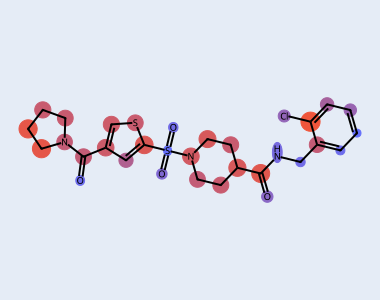

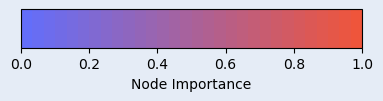



--- Worst Prediction (Index: 1142) ---

GNNExplainer (Nodes): Worst Prediction | Prediction: 987.05
-----------------------------------------------------------


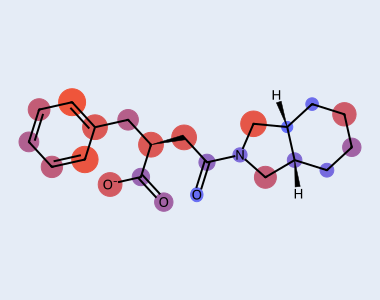

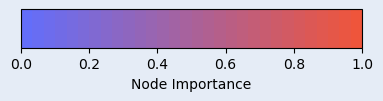

In [65]:
def highlight_atoms_from_scores(
    smiles: str,
    atom_scores,
    title: str= '',
    pred: np.ndarray=None,
    size=(350, 300),
    use_abs=False,
    show_colorbar=True,
    
):
    """
    Atom highlight visualization for node explanations.
    Args:
        smiles: smiles string of molecule
        atom_scores: array-like of length == mol.GetNumAtoms()
        title: Plot title
        pred: Prediction value to display
        size: (width, height) of the output image in pixels
        use_abs: whether to use absolute values of scores for coloring

    """
    scores = np.asarray(atom_scores, dtype=float).reshape(-1)
    mol = Chem.MolFromSmiles(smiles)
    n = mol.GetNumAtoms()
    if scores.shape[0] != n:
        raise ValueError(f"atom_scores length {scores.shape[0]} != num atoms {n}")
    vals = np.abs(scores) if use_abs else scores
    
    # normalize only over kept atoms (avoid divide-by-zero)
    vmin = float(vals.min()) if vals.size else 0.0
    vmax = float(vals.max()) if vals.size else 1.0
    
    if vmax == vmin:
        vmax = vmin + 1e-12

    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    highlight_atoms = [i for i in range(n)]
    highlight_atom_colors = {}
    highlight_atom_radii = {}

    for i in highlight_atoms:
        color = _COLOR_CMAP(norm(vals[i]))
        highlight_atom_colors[i] = color
        highlight_atom_radii[i] = 0.25 + 0.35 * float(norm(vals[i]))
    
    # Draw
    drawer = Draw.MolDraw2DSVG(int(size[0]), int(size[1]))
    opts = drawer.drawOptions()
    opts.useBWAtomPalette()
    opts.backgroundColour = BG_RGBA 
    
    Draw.rdMolDraw2D.PrepareAndDrawMolecule(
        drawer,
        mol,
        highlightAtoms=highlight_atoms,
        highlightAtomColors=highlight_atom_colors,
        highlightAtomRadii=highlight_atom_radii,
    )
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()

    # Display title and prediction
    if title:
        pred_str = f" | Prediction: {pred:.2f}" if pred is not None else ""
        display_title = f"{title}{pred_str}"
        print(f"\n{display_title}")
        print("-" * len(display_title))
    display(SVG(svg))
    
    # Show colorbar for reference
    if show_colorbar :
        fig = plt.figure(figsize=(4.4, 0.5), facecolor="#E5ECF6")
        ax = fig.add_subplot(111)
        fig.patch.set_facecolor("#E5ECF6")
        norm = colors.Normalize(vmin=0, vmax=1)
        cbar = colorbar.ColorbarBase(ax, cmap=_COLOR_CMAP, norm=norm, 
                               orientation='horizontal')
        cbar.set_label('Node Importance', fontsize=10)
        plt.show()


def explain_gcn_nodes(
    model,
    smiles: str,
    device: torch.device = torch.device("cpu"),
    title: str = "",
    epochs: int = 100,
):
    """Node importance using PyG Explainer (GNNExplainer) for graph-level regression."""
    model = model.to(device).eval()
    data, _explicit_h_used = _smiles_to_data_best_effort(smiles, device)
    wrapper = GraphModelWrapper(model).to(device)

    explainer = Explainer(
        model=wrapper,
        algorithm=GNNExplainer(epochs=epochs),
        explanation_type="model",
        node_mask_type="object",   # <-- node importance (per-node mask)
        edge_mask_type=None,       # <-- disable edge mask if you only want node importance
        model_config=dict(
            mode="regression",
            task_level="graph",
            return_type="raw",
        ),
    )

    batch = getattr(data, "batch", None)
    if batch is None:
        batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)

    explanation = explainer(
        x=data.x,
        edge_index=data.edge_index,
        batch=batch,
    )

    # node_mask can be shape [num_nodes] OR [num_nodes, num_features]
    node_mask = explanation.node_mask.detach().cpu().numpy()
    node_mask = np.asarray(node_mask, dtype=float)
    
    # normalize to 0..1 for consistent coloring
    denom = (node_mask.max() - node_mask.min()) + 1e-12
    node_scores_norm = (node_mask - node_mask.min()) / denom
    pred_full = _predict_single(model, data, device)
    highlight_atoms_from_scores(smiles, node_scores_norm,title,pred_full, size=(380, 300))
    
    return node_mask, node_scores_norm

#best_idx= 11968
#worst_idx= 9251
print(f"--- Best Prediction (Index: {best_idx}) ---")
_ = explain_gcn_nodes(
    gcn_model,
    ftest_set.iloc[best_idx]["SMILES"],
    device=torch.device("cpu"),
    title="GNNExplainer (Nodes): Best Prediction",
 )

print("\n" + "=" * 80 + "\n")

print(f"--- Worst Prediction (Index: {worst_idx}) ---")
_ = explain_gcn_nodes(
    gcn_model,
    ftest_set.iloc[worst_idx]["SMILES"],
    device=torch.device("cpu"),
    title="GNNExplainer (Nodes): Worst Prediction",
 )

# Test code-not used

## Test-1: PYG built-in explainer+networkx

In [ ]:
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch_geometric.explain import Explainer, GNNExplainer

# small -> large
cmap = LinearSegmentedColormap.from_list(
    "blue_to_red",
    ["#636EFA", "#EF553B"],
    N=256,
)

class GraphModelWrapper(torch.nn.Module):
    """Wraps your model so PyG Explainer can call forward(x, edge_index, batch=...)."""
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x, edge_index, batch=None, **kwargs):
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        data = Data(x=x, edge_index=edge_index, batch=batch)
        return self.model(data)

def explain_gcn_nodes_pyg(
    model,
    smiles: str,
    device: torch.device = torch.device("cpu"),
    title: str = "",
    epochs: int = 200,
):
    """Node importance using PyG Explainer (GNNExplainer) for graph-level regression."""
    model = model.to(device).eval()
    data, _explicit_h_used = _smiles_to_data_best_effort(smiles, device)

    wrapper = GraphModelWrapper(model).to(device)

    explainer = Explainer(
        model=wrapper,
        algorithm=GNNExplainer(epochs=epochs),
        explanation_type="model",
        node_mask_type="object",   # <-- node importance (per-node mask)
        edge_mask_type=None,       # <-- disable edge mask if you only want node importance
        model_config=dict(
            mode="regression",
            task_level="graph",
            return_type="raw",
        ),
    )

    batch = getattr(data, "batch", None)
    if batch is None:
        batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)

    explanation = explainer(
        x=data.x,
        edge_index=data.edge_index,
        batch=batch,
    )

    # node_mask can be shape [num_nodes] OR [num_nodes, num_features]
    node_mask = explanation.node_mask.detach().cpu().numpy()
    node_mask = np.asarray(node_mask, dtype=float)
    if node_mask.ndim == 2:
        node_scores = np.abs(node_mask).sum(axis=1)
    else:
        node_scores = np.abs(node_mask)

    # normalize to 0..1 for consistent coloring
    denom = (node_scores.max() - node_scores.min()) + 1e-12
    node_scores_norm = (node_scores - node_scores.min()) / denom

    # visualize on NetworkX
    g_nx = to_networkx(data, node_attrs=["x"]).to_undirected()
    pos = nx.spring_layout(g_nx, seed=0)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.axis("off")

    nx.draw_networkx_edges(g_nx, pos, ax=ax, alpha=0.6, width=1.5)
    nodes = nx.draw_networkx_nodes(
        g_nx,
        pos,
        ax=ax,
        node_color=node_scores_norm,
        cmap=cmap,
        vmin=0.0,
        vmax=1.0,
        edgecolors="black",
    )

    # colorbar = legend for the colormap
    sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0.0, 1.0), cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Node importance")

    ax.set_title(title if title else "GCN GNNExplainer (Nodes)")
    plt.show()

    return node_scores, node_scores_norm

best_idx= 11968
worst_idx= 9251
print(f"--- Best Prediction (Index: {best_idx}) ---")
_ = explain_gcn_nodes_pyg(
    gcn_model,
    ftest_set.iloc[best_idx]["SMILES"],
    device=torch.device("cpu"),
    title="GCN IG (Nodes): Best Prediction",
 )

print("\n" + "=" * 80 + "\n")

print(f"--- Worst Prediction (Index: {worst_idx}) ---")
_ = explain_gcn_nodes_pyg(
    gcn_model,
    ftest_set.iloc[worst_idx]["SMILES"],
    device=torch.device("cpu"),
    title="GCN IG (Nodes): Worst Prediction",
 )

## Test-2: PYG built-in explainer for edge+networkx

In [ ]:
# default explainer

import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import SVG, display
from rdkit import Chem
from rdkit.Chem.Draw import SimilarityMaps, rdMolDraw2D
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, add_self_loops
from torch_geometric.explain import Explainer, GNNExplainer

BG_RGBA = (229 / 255, 236 / 255, 246 / 255, 1)  # notebook bg
BG_HEX = "#E5ECF6"

def _style_mpl_ax(ax=None):
    if ax is None:
        ax = plt.gca()
    fig = ax.figure
    fig.patch.set_facecolor(BG_RGBA)
    ax.set_facecolor(BG_RGBA)
    ax.axis("off")
    return ax

def _get_atomic_symbol(atomic_number: int) -> str:
    pt = Chem.GetPeriodicTable()
    return pt.GetElementSymbol(int(atomic_number))

def _node_labels_from_x(x: torch.Tensor):
    """Best-effort atom label extraction from one-hot-ish x."""
    x_np = x.detach().cpu().numpy()
    labels = {}
    for i in range(x_np.shape[0]):
        row = x_np[i]
        idx = None
        for j in range(min(100, row.shape[0])):
            if row[j] == 1.0:
                idx = j
                break
        labels[i] = _get_atomic_symbol(idx + 1) if idx is not None else str(i)
    return labels

def _smiles_to_data_best_effort(smiles: str, device: torch.device):
    """Try to build a PyG Data that matches the trained model's featurization."""
    from pyg_chemprop_utils import smiles2data
    last_err = None
    for explicit_h in (False, True):
        try:
            data = smiles2data(smiles, explicit_h=explicit_h)
            if data is None:
                raise ValueError("smiles2data returned None")
            data = data.to(device)
            return data, explicit_h
        except Exception as e:
            last_err = e
            continue
    raise RuntimeError(f"Failed to featurize SMILES with explicit_h False/True: {last_err}")

def _predict_single(model, data: Data, device: torch.device) -> float:
    model = model.to(device)
    model.eval()
    if getattr(data, "batch", None) is None:
        data.batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)
    with torch.no_grad():
        out = model(data)
        out = out.squeeze()
        return float(out.reshape(-1)[0].item())

class GraphModelWrapper(torch.nn.Module):
    """Wraps the GCN model to accept (x, edge_index, batch) arguments required by PyG Explainer."""
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x, edge_index, batch=None, **kwargs):
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        # Reconstruct Data object
        data = Data(x=x, edge_index=edge_index, batch=batch)
        return self.model(data)

def explain_gcn_edges_pyg(
    model,
    smiles: str,
    device: torch.device = torch.device("cpu"),
    title: str = "",
    epochs: int = 200,
    ):
    """Edge importance using PyG's built-in Explainer (GNNExplainer)."""
    model = model.to(device)
    model.eval()

    data, _explicit_h_used = _smiles_to_data_best_effort(smiles, device)
    
    # Wrap model for Explainer
    wrapper = GraphModelWrapper(model).to(device)
    
    # Configure Explainer
    explainer = Explainer(
        model=wrapper,
        algorithm=GNNExplainer(epochs=epochs),
        explanation_type='model',
        node_mask_type=None,
        edge_mask_type='object',
        model_config=dict(
            mode='regression',
            task_level='graph',
            return_type='raw',
        ),
    )
    
    # Run explanation
    batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)
    explanation = explainer(
        x=data.x, 
        edge_index=data.edge_index, 
        batch=batch
    )
    
    edge_mask = explanation.edge_mask.cpu().detach().numpy()
    if edge_mask.max() > 0:
        edge_mask = edge_mask / edge_mask.max()

    pred_full = _predict_single(model, data, device)

    # Visualization
    g_nx = to_networkx(data, node_attrs=["x"]).to_undirected()
    labels = _node_labels_from_x(data.x)
    pos = nx.spring_layout(g_nx, seed=0)

    # Aggregate directed edge scores to undirected edges
    edge_scores_dict = {}
    e_np = data.edge_index.cpu().numpy()
    for i in range(e_np.shape[1]):
        u, v = int(e_np[0, i]), int(e_np[1, i])
        key = tuple(sorted((u, v)))
        current = edge_scores_dict.get(key, 0.0)
        edge_scores_dict[key] = max(current, float(edge_mask[i]))

    edge_color = []
    widths = []
    for (u, v) in g_nx.edges():
        key = tuple(sorted((u, v)))
        w = edge_scores_dict.get(key, 0.0)
        edge_color.append(w)
        widths.append(1.0 + 6.0 * w)
    fig, ax = plt.subplots(figsize=(4, 4))
    _style_mpl_ax(ax)
    nx.draw_networkx_nodes(g_nx, pos, ax=ax, node_color="white", edgecolors="black")
    nx.draw_networkx_labels(g_nx, pos, labels=labels, ax=ax, font_size=10)
    nx.draw_networkx_edges(
        g_nx,
        pos,
        ax=ax,
        width=widths,
        edge_color=edge_color,
        edge_cmap=plt.cm.Blues,
    )
    plt.title(title if title else f"GCN GNNExplainer (Edges) | pred={pred_full:.3f}")
    plt.show()

    return edge_mask, pred_full

print(f"--- Best Prediction (Index: {best_idx}) ---")
_ = explain_gcn_edges_pyg(
    gcn_model,
    ftest_set.iloc[best_idx]["SMILES"],
    device=torch.device("cpu"),
    title="GCN Edge Explanation: Best Prediction",
 )

print("\n" + "=" * 80 + "\n")

print(f"--- Worst Prediction (Index: {worst_idx}) ---")
_ = explain_gcn_edges_pyg(
    gcn_model,
    ftest_set.iloc[worst_idx]["SMILES"],
    device=torch.device("cpu"),
    title="GCN Edge Explanation: Worst Prediction",
)

## Test-3: Ablation explainer for edges-networkx

In [ ]:
# Ablation explanation
import re
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import SVG, display
from captum.attr import IntegratedGradients, Saliency, FeatureAblation
from rdkit import Chem
from rdkit.Chem.Draw import SimilarityMaps, rdMolDraw2D
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, add_self_loops

BG_RGBA = (229 / 255, 236 / 255, 246 / 255, 1)  # notebook bg
BG_HEX = "#E5ECF6"


def _style_mpl_ax(ax=None):
    if ax is None:
        ax = plt.gca()
    fig = ax.figure
    fig.patch.set_facecolor(BG_RGBA)
    ax.set_facecolor(BG_RGBA)
    ax.axis("off")
    return ax

def _get_atomic_symbol(atomic_number: int) -> str:
    pt = Chem.GetPeriodicTable()
    return pt.GetElementSymbol(int(atomic_number))


def _node_labels_from_x(x: torch.Tensor):
    """Best-effort atom label extraction from one-hot-ish x."""
    x_np = x.detach().cpu().numpy()
    labels = {}
    for i in range(x_np.shape[0]):
        row = x_np[i]
        idx = None
        for j in range(min(100, row.shape[0])):
            if row[j] == 1.0:
                idx = j
                break
        labels[i] = _get_atomic_symbol(idx + 1) if idx is not None else str(i)
    return labels


def _smiles_to_data_best_effort(smiles: str, device: torch.device):
    """Try to build a PyG Data that matches the trained model's featurization."""
    from pyg_chemprop_utils import smiles2data
    last_err = None
    for explicit_h in (False, True):
        try:
            data = smiles2data(smiles, explicit_h=explicit_h)
            if data is None:
                raise ValueError("smiles2data returned None")
            data = data.to(device)
            return data, explicit_h
        except Exception as e:
            last_err = e
            continue
    raise RuntimeError(f"Failed to featurize SMILES with explicit_h False/True: {last_err}")


def _predict_single(model, data: Data, device: torch.device) -> float:
    model = model.to(device)
    model.eval()
    if getattr(data, "batch", None) is None:
        data.batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)
    with torch.no_grad():
        out = model(data)
        out = out.squeeze()
        return float(out.reshape(-1)[0].item())

def explain_gcn_edges_ablation(
    model,
    smiles: str,
    device: torch.device = torch.device("cpu"),
    title: str = "",
    threshold: float = 0.5,
):
    """Edge importance via Captum FeatureAblation on an edge-keep mask."""
    model = model.to(device)
    model.eval()

    data, _explicit_h_used = _smiles_to_data_best_effort(smiles, device)
    x0 = data.x.detach()
    edge_index0 = data.edge_index.detach()
    num_nodes = x0.size(0)
    batch0 = torch.zeros(num_nodes, dtype=torch.long, device=device)

    e0 = edge_index0.cpu().numpy()
    undirected = {}  # (min(u,v), max(u,v)) -> list[dir_edge_idx]
    for j in range(e0.shape[1]):
        u = int(e0[0, j])
        v = int(e0[1, j])
        key = (u, v) if u <= v else (v, u)
        undirected.setdefault(key, []).append(j)

    keys = list(undirected.keys())
    key_to_i = {k: i for i, k in enumerate(keys)}
    num_u = len(keys)
    if num_u == 0:
        raise ValueError("Graph has no edges; cannot do edge ablation.")

    def forward_on_edge_keep(mask_u: torch.Tensor) -> torch.Tensor:
        # Handle batch dimension
        if mask_u.dim() == 1:
            mask_u = mask_u.unsqueeze(0)
            
        batch_size = mask_u.size(0)
        outputs = []
        
        for b in range(batch_size):
            m = mask_u[b]
            keep_dir = []
            for i, key in enumerate(keys):
                if float(m[i].item()) > threshold:
                    keep_dir.extend(undirected[key])

            if len(keep_dir) == 0:
                ei = torch.empty((2, 0), dtype=torch.long, device=device)
                ei, _ = add_self_loops(ei, num_nodes=num_nodes)
            else:
                idx = torch.tensor(keep_dir, dtype=torch.long, device=device)
                ei = edge_index0.index_select(1, idx)
                ei, _ = add_self_loops(ei, num_nodes=num_nodes)

            g = Data(x=x0, edge_index=ei, batch=batch0)
            out = model(g)
            # Handle different output shapes
            if out.dim() > 1:
                out = out.squeeze()
            if out.dim() == 0:
                out = out.unsqueeze(0)
            outputs.append(out[0])  # Get the first (and only) prediction
        
        return torch.stack(outputs)

    # Create mask for each undirected edge
    mask_init = torch.ones(num_u, dtype=torch.float32, device=device)
    baseline = torch.zeros(num_u, dtype=torch.float32, device=device)
    
    # Create feature mask to indicate each edge is a separate feature
    feature_mask = torch.ones(num_u, dtype=torch.long, device=device)
    
    ablator = FeatureAblation(forward_on_edge_keep)
    
    # Get attributions for each edge
    attr = ablator.attribute(
        mask_init.unsqueeze(0),  # Add batch dimension
        baselines=baseline.unsqueeze(0),  # Add batch dimension
        feature_mask=feature_mask,
        perturbations_per_eval=1
    )
    
    # Debug print
    print(f"attr shape: {attr.shape}")
    
    # Remove batch dimension if present
    if attr.dim() == 2:
        attr = attr.squeeze(0)
    
    edge_scores = attr.detach().cpu().numpy()
    
    # Ensure we have the right number of scores
    if len(edge_scores) != num_u:
        # If we still have issues, try a different approach
        print(f"Warning: Expected {num_u} edge scores, got {len(edge_scores)}")
        print(f"edge_scores shape: {edge_scores.shape}")
        print(f"edge_scores: {edge_scores}")
        
        # Fallback: manually compute attributions
        edge_scores = []
        with torch.no_grad():
            full_output = forward_on_edge_keep(mask_init.unsqueeze(0))
            full_pred = full_output.item()
            
            for i in range(num_u):
                # Create mask with this edge removed
                mask_ablated = mask_init.clone()
                mask_ablated[i] = 0.0
                ablated_output = forward_on_edge_keep(mask_ablated.unsqueeze(0))
                ablated_pred = ablated_output.item()
                
                # Compute attribution as absolute difference
                attribution = abs(full_pred - ablated_pred)
                edge_scores.append(attribution)
        
        edge_scores = np.array(edge_scores)
        print(f"Using fallback method, got {len(edge_scores)} scores")
    
    # Normalize if we have scores
    if edge_scores.max() > 0:
        edge_scores = edge_scores / edge_scores.max()

    pred_full = _predict_single(model, data, device)

    g_nx = to_networkx(data, node_attrs=["x"]).to_undirected()
    labels = _node_labels_from_x(data.x)
    pos = nx.spring_layout(g_nx, seed=0)

    edge_color = []
    widths = []
    for (u, v) in g_nx.edges():
        key = (u, v) if u <= v else (v, u)
        i = key_to_i.get(key, None)
        w = float(edge_scores[i]) if i is not None else 0.0
        edge_color.append(w)
        widths.append(1.0 + 6.0 * w)

    fig, ax = plt.subplots(figsize=(8, 5))
    _style_mpl_ax(ax)
    nx.draw_networkx_nodes(g_nx, pos, ax=ax, node_color="white", edgecolors="black")
    nx.draw_networkx_labels(g_nx, pos, labels=labels, ax=ax, font_size=10)
    nx.draw_networkx_edges(
        g_nx,
        pos,
        ax=ax,
        width=widths,
        edge_color=edge_color,
        edge_cmap=plt.cm.Blues,
        edge_vmin=0.0,
        edge_vmax=1.0 if len(edge_color) > 0 else 1.0,
    )
    plt.title(title if title else f"GCN edge ablation | pred={pred_full:.3f}")
    plt.show()

    return edge_scores, pred_full

print(f"--- Best Prediction (Index: {best_idx}) ---")

_ = explain_gcn_edges_ablation(
    gcn_model,
    ftest_set.iloc[best_idx]["SMILES"],
    device=torch.device("cpu"),
    title="GCN Edge Ablation: Best Prediction",
 )

print("\n" + "=" * 80 + "\n")

print(f"--- Worst Prediction (Index: {worst_idx}) ---")
_ = explain_gcn_edges_ablation(
    gcn_model,
    ftest_set.iloc[worst_idx]["SMILES"],
    device=torch.device("cpu"),
    title="GCN Edge Ablation: Worst Prediction",
 )

## Test-4: Ablation explainer for nodes

In [ ]:
import re
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import SVG, display
from captum.attr import IntegratedGradients, Saliency, FeatureAblation
from rdkit import Chem
from rdkit.Chem.Draw import SimilarityMaps, rdMolDraw2D
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, add_self_loops

BG_RGBA = (229 / 255, 236 / 255, 246 / 255, 1)  # #E5ECF6
BG_HEX = "#E5ECF6"


def _style_mpl_ax(ax=None):
    if ax is None:
        ax = plt.gca()
    fig = ax.figure
    fig.patch.set_facecolor(BG_RGBA)
    ax.set_facecolor(BG_RGBA)
    #ax.axis("off")
    return ax


def _display_similarity_map_from_weights(
    mol,
    weights,
    title: str = "",
    size=(320, 320),
    color_map=None,
    alpha: float = 0.5,
    contour_lines: int = 0,
    bg_hex: str = BG_HEX,
    bg_rgba=BG_RGBA,
    ):
    """Compatibility wrapper for RDKit SimilarityMaps across versions.

    Some RDKit builds require a positional `draw2d` argument. Newer builds return a Matplotlib figure.
    This function supports both and enforces the notebook's background color.
    """
    if color_map is None:
        color_map = plt.cm.coolwarm

    try:
        fig = SimilarityMaps.GetSimilarityMapFromWeights(
            mol,
            weights,
            colorMap=color_map,
            size=size,
            alpha=alpha,
            contourLines=contour_lines,
        )
        ax = plt.gca()
        fig.patch.set_facecolor(bg_rgba)
        ax.set_facecolor(bg_rgba)
        ax.axis("off")
        if title:
            plt.title(title)
        plt.show()
        return fig
    except TypeError:
        drawer = rdMolDraw2D.MolDraw2DSVG(int(size[0]), int(size[1]))
        SimilarityMaps.GetSimilarityMapFromWeights(
            mol,
            weights,
            drawer,
            colorMap=color_map,
            size=size,
            alpha=alpha,
            contourLines=contour_lines,
        )
        drawer.FinishDrawing()
        svg_data = drawer.GetDrawingText()
        
        bg_rect = f'<rect width="100%" height="100%" fill="{bg_hex}"/>'
        if isinstance(svg_data, str):
            svg_data = re.sub(r'fill:\s*#FFFFFF', f'fill:{bg_hex}', svg_data, flags=re.IGNORECASE)
            svg_data = re.sub(r'fill:\s*#DDDCDB', f'fill:{bg_hex}', svg_data, flags=re.IGNORECASE)
            svg_data = re.sub(r'stroke:*#DDDCDB',f'stroke:{bg_hex}', svg_data, flags=re.IGNORECASE)
            svg_data = re.sub(r'fill:\s*white', f'fill:{bg_hex}', svg_data, flags=re.IGNORECASE)
            svg_data = re.sub(r'rect style="opacity:1.0;fill:\s*#FFFFFF;stroke:none"', f'rect style="opacity:1.0;fill:{bg_hex};stroke:none"', svg_data, flags=re.IGNORECASE)
            svg_data = re.sub(r'rect style="opacity:1.0;fill:\s*#DDDCDB;stroke:none"', f'rect style="opacity:1.0;fill:{bg_hex};stroke:none"', svg_data, flags=re.IGNORECASE)

        if "<!-- END OF HEADER -->" in svg_data:
            svg_data = svg_data.replace("<!-- END OF HEADER -->", f"<!-- END OF HEADER -->\n{bg_rect}")
        else:
            svg_data = re.sub(r'(<svg[^>]*>)', lambda m: m.group(1) + f'\n{bg_rect}', svg_data, count=1)
        svg_data = re.sub(r'(<svg[^>]*>)', r"\1\n" + bg_rect, svg_data, count=1)
        display(SVG(svg_data))
        return svg_data


def _smiles_to_data_best_effort(smiles: str, device: torch.device):
    """Try to build a PyG Data that matches the trained model's featurization."""
    from pyg_chemprop_utils import smiles2data
    last_err = None
    for explicit_h in (False, True):
        try:
            data = smiles2data(smiles, explicit_h=explicit_h)
            if data is None:
                raise ValueError("smiles2data returned None")
            data = data.to(device)
            return data, explicit_h
        except Exception as e:
            last_err = e
            continue
    raise RuntimeError(f"Failed to featurize SMILES with explicit_h False/True: {last_err}")


def _predict_single(model, data: Data, device: torch.device) -> float:
    model = model.to(device)
    model.eval()
    if getattr(data, "batch", None) is None:
        data.batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)
    with torch.no_grad():
        out = model(data)
        out = out.squeeze()
        return float(out.reshape(-1)[0].item())


def explain_gcn_nodes_captum(
    model,
    smiles: str,
    device: torch.device = torch.device("cpu"),
    method: str = "ig",
    n_steps: int = 64,
    title: str = "",
    ):
    """Node-feature attribution (IG or Saliency) visualized with RDKit SimilarityMaps.

    Captum's IG expands `x` along dim=0 (steps batching). We replicate `edge_index`
    with node-index offsets and build a matching `batch` vector.
    """
    model = model.to(device)
    model.eval()

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES")

    data, explicit_h_used = _smiles_to_data_best_effort(smiles, device)
    x0 = data.x.detach().clone().requires_grad_(True)
    edge_index0 = data.edge_index
    num_nodes = x0.size(0)

    def forward_on_x(x_in: torch.Tensor) -> torch.Tensor:
        if x_in.dim() != 2:
            raise ValueError(f"Expected x_in to be 2D [*, F], got {tuple(x_in.shape)}")
        total_nodes = x_in.size(0)
        if total_nodes % num_nodes != 0:
            raise ValueError(
                f"x_in first dim ({total_nodes}) not divisible by num_nodes ({num_nodes})."
            )
        num_graphs = total_nodes // num_nodes

        if num_graphs == 1:
            batch = torch.zeros(num_nodes, dtype=torch.long, device=device)
            edge_index = edge_index0
        else:
            edge_index = torch.cat(
                [edge_index0 + i * num_nodes for i in range(num_graphs)], dim=1
            )
            batch = torch.arange(num_graphs, device=device).repeat_interleave(num_nodes)

        g = Data(x=x_in, edge_index=edge_index, batch=batch)
        out = model(g).squeeze().reshape(-1)
        return out

    pred = _predict_single(model, data, device)

    m = method.lower().strip()
    if m == "ig":
        explainer = IntegratedGradients(forward_on_x)
        baseline = torch.zeros_like(x0)
        attr = explainer.attribute(x0, baselines=baseline, n_steps=n_steps)
    elif m == "saliency":
        explainer = Saliency(forward_on_x)
        attr = explainer.attribute(x0)
    else:
        raise ValueError("method must be 'ig' or 'saliency'")

    node_scores = attr.detach().cpu().numpy().sum(axis=1).astype(float)

    num_heavy = mol.GetNumAtoms()
    if explicit_h_used:
        mol_h = Chem.AddHs(mol)
        weights = []
        for i in range(num_heavy):
            w = float(node_scores[i])
            atom = mol_h.GetAtomWithIdx(i)
            for nbr in atom.GetNeighbors():
                if nbr.GetAtomicNum() == 1:
                    w += float(node_scores[nbr.GetIdx()])
            weights.append(w)
    else:
        weights = [float(node_scores[i]) for i in range(min(num_heavy, len(node_scores)))]

    _display_similarity_map_from_weights(
        mol,
        weights,
        title=title if title else f"GCN {m.upper()} (nodes) | pred={pred:.3f}",
        size=(300, 300),
        color_map=plt.cm.coolwarm,
        alpha=0.5,
        contour_lines=0,
    )

    return weights, pred

best_idx= 11968
worst_idx= 9251
print(f"--- Best Prediction (Index: {best_idx}) ---")
_ = explain_gcn_nodes_captum(
    gcn_model,
    ftest_set.iloc[best_idx]["SMILES"],
    device=torch.device("cpu"),
    method="ig",
    n_steps=64,
    title="GCN IG (Nodes): Best Prediction",
 )

print("\n" + "=" * 80 + "\n")

print(f"--- Worst Prediction (Index: {worst_idx}) ---")
_ = explain_gcn_nodes_captum(
    gcn_model,
    ftest_set.iloc[worst_idx]["SMILES"],
    device=torch.device("cpu"),
    method="ig",
    n_steps=64,
    title="GCN IG (Nodes): Worst Prediction",
 )